In [2]:
import pypsa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("bmh")
%matplotlib inline

**Senstivity analysis 1 - Conventional Resources Elimination**

In [3]:
n1 = pypsa.Network("capacity/elec_s_37_ec_lv1.25_Co2L0-2H-EQ0.8c-MDES+c1-mdes+c3-mdes+e0.7.nc")

INFO:pypsa.io:Imported network elec_s_37_ec_lv1.25_Co2L0-2H-EQ0.8c-MDES+c1-mdes+c3-mdes+e0.7.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


In [4]:
n1.objective/1e9

67.07854407286584

In [5]:
n1.stores.groupby(n1.stores.carrier).capital_cost.mean()

carrier
H2           84.096918
MDES         81.000000
battery    6043.980263
Name: capital_cost, dtype: float64

In [6]:
n1_re = pypsa.Network("capacity/elec_s_37_ec_lv1.25_Co2L0-2H-EQ0.8c-re-MDES+c1-mdes+c3-mdes+e0.7.nc")

INFO:pypsa.io:Imported network elec_s_37_ec_lv1.25_Co2L0-2H-EQ0.8c-re-MDES+c1-mdes+c3-mdes+e0.7.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


In [7]:
n1_re.objective/1e9

88.92876771146882

In [8]:
n1_re.generators.carrier.unique()

array(['offwind-ac', 'onwind', 'ror', 'solar', 'offwind-dc'], dtype=object)

In [9]:
n1_re.stores.carrier.unique()

array(['H2', 'battery', 'MDES'], dtype=object)

In [10]:
d_store_re = n1_re.stores.groupby(n1_re.stores.carrier).e_nom_opt.sum()

In [11]:
d_store = n1.stores.groupby(n1.stores.carrier).e_nom_opt.sum()

In [12]:
(d_store_re - d_store)/d_store_re

carrier
H2        -0.029543
MDES       0.248106
battery    0.062173
Name: e_nom_opt, dtype: float64

In [13]:
d_store_re.sum()-d_store.sum()

23706898.109501883

In [14]:
off_re = pypsa.Network("elec_s_37_ec_lv1.25_Co2L0-2H-EQ0.8c-re-off.nc")

INFO:pypsa.io:Imported network elec_s_37_ec_lv1.25_Co2L0-2H-EQ0.8c-re-off.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


In [15]:
off_re.objective/1e9

128.87834662778974

In [16]:
off_re.stores.carrier.unique()

array(['H2', 'battery'], dtype=object)

In [17]:
n50 = pypsa.Network("elec_s_37_ec_lv1.25_Co2L0-2H-EQ0.8c-re-MDES+c50-mdes+c1-mdes+e0.8.nc")

INFO:pypsa.io:Imported network elec_s_37_ec_lv1.25_Co2L0-2H-EQ0.8c-re-MDES+c50-mdes+c1-mdes+e0.8.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


In [18]:
(off_re.objective - n50.objective)/(off_re.objective)*100

1.0041082235762393

In [19]:
off = pypsa.Network("elec_s_37_ec_lv1.25_Co2L0-2H-EQ0.8c-off.nc")

INFO:pypsa.io:Imported network elec_s_37_ec_lv1.25_Co2L0-2H-EQ0.8c-off.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


In [20]:
off.objective/1e9

94.91518573119832

In [21]:
e_off_re = off_re.stores.groupby("carrier").e_nom_opt.sum().rename("pure re, no MDES")
e_re = n1_re.stores.groupby("carrier").e_nom_opt.sum().rename("pure re, with MDES")
e1_off = off.stores.groupby("carrier").e_nom_opt.sum().rename("base, no MDES")
e1 = n1.stores.groupby("carrier").e_nom_opt.sum().rename("base, with MDES")

In [22]:
stores = pd.concat([e_off_re,e_re,e1_off, e1], axis=1)
stores.sum(axis=0)

pure re, no MDES      1.253364e+08
pure re, with MDES    9.570918e+07
base, no MDES         7.993968e+07
base, with MDES       7.200228e+07
dtype: float64

In [23]:
c_off_re = off_re.objective/1e9
c_re = n1_re.objective/1e9
c_off = off.objective/1e9
c = n1.objective/1e9

In [24]:
system_cost = [c_off_re, c_re, c_off, c]
index = ["pure re, no MDES", "pure re, with MDES", "base, no MDES", "base, with MDES"]
system_cost = pd.Series(system_cost, index=index, name='system cost [b€]')

In [25]:
system_cost=system_cost.to_frame()

In [26]:
stores

,"pure re, no MDES","pure re, with MDES","base, no MDES","base, with MDES"
carrier,,,,
H2,1.236522e+08,9.390665e+01,7.869422e+07,9.668094e+01
battery,1.684206e+06,2.102830e+05,1.245459e+06,1.972091e+05
MDES,NaN,9.549880e+07,NaN,7.180497e+07


In [27]:
data = pd.concat([stores, system_cost.T], axis=0)

In [28]:
data.iloc[:3,:].T

,H2,battery,MDES
"pure re, no MDES",1.236522e+08,1.684206e+06,NaN
"pure re, with MDES",9.390665e+01,2.102830e+05,9.549880e+07
"base, no MDES",7.869422e+07,1.245459e+06,NaN
"base, with MDES",9.668094e+01,1.972091e+05,7.180497e+07


In [29]:
data.loc["system cost [b€]"]

pure re, no MDES      128.878347
pure re, with MDES     88.928768
base, no MDES          94.915186
base, with MDES        67.078544
Name: system cost [b€], dtype: float64

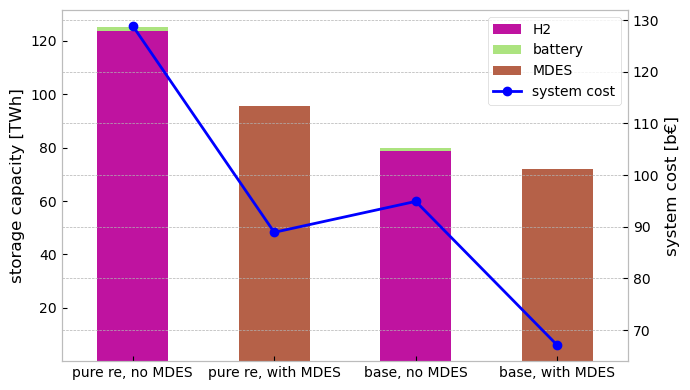

In [30]:
x = data.columns
y1 = data.iloc[:3,:].div(1e6)
y2 = data.loc["system cost [b€]"]

fig, ax1 = plt.subplots(figsize=(7,4))
fig.patch.set_facecolor('white')
ax1.set_facecolor('white')
y1.T.plot(kind='bar', color=data.iloc[:3,:].index.map(n1.carriers.color), stacked=True, legend=False, ax=ax1, zorder=1)
ax1.set_ylabel('storage capacity [TWh]')

ax2 = ax1.twinx()
ax2.plot(x, y2, color='blue', marker='o', zorder=2, label="system cost")
ax2.set_ylabel('system cost [b€]')
ax1.set_xticklabels(x, rotation=0)
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(handles1 + handles2, labels1 + labels2, loc='upper right',facecolor='white')

ax1.grid(False)
plt.tight_layout()
plt.savefig("Sensitivity analysis 1.pdf", dpi=750)
plt.show()

In [31]:
n5_re = pypsa.Network("elec_s_37_ec_lv1.25_Co2L0-2H-EQ0.8c-re-MDES+c5-mdes+c11-mdes+e0.7.nc")

INFO:pypsa.io:Imported network elec_s_37_ec_lv1.25_Co2L0-2H-EQ0.8c-re-MDES+c5-mdes+c11-mdes+e0.7.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


In [32]:
n5_re.objective/1e9

123.93598492951216

In [33]:
(c_off_re - n5_re.objective/1e9)/c_off_re*100

3.8349046427104536

In [34]:
n5_re.stores.carrier.unique()

array(['H2', 'battery', 'MDES'], dtype=object)

In [35]:
n5_re.stores.capital_cost.unique()

array([  84.09691752, 6043.98026333,  405.        ])

In [36]:
n5_re.generators.carrier.unique()

array(['offwind-ac', 'onwind', 'ror', 'solar', 'offwind-dc'], dtype=object)

In [37]:
n5_re.links.carrier.unique()

array(['DC', 'H2 electrolysis', 'H2 fuel cell', 'battery charger',
       'battery discharger', 'mdes-charger', 'mdes-discharger'],
      dtype=object)

In [38]:
n5_re.links.groupby(n5_re.links.carrier).capital_cost.mean()

carrier
DC                    57604.011689
H2 electrolysis       22016.685483
H2 fuel cell          76951.001091
battery charger        9082.650164
battery discharger        0.000000
mdes-charger          44550.000000
mdes-discharger       44550.000000
Name: capital_cost, dtype: float64

**Senstivity analysis 2 - synergies of MDES technologies**

In [39]:
n5_11 = pypsa.Network("capacity/elec_s_37_ec_lv1.25_Co2L0-2H-EQ0.8c-MDES+c5-mdes+c11-mdes+e0.7.nc")

INFO:pypsa.io:Imported network elec_s_37_ec_lv1.25_Co2L0-2H-EQ0.8c-MDES+c5-mdes+c11-mdes+e0.7.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


In [40]:
n5_11.objective/1e9

91.43853845061051

In [41]:
single_e = n5_11.stores.groupby(n5_11.stores.carrier).e_nom_opt.sum().div(1e6)

In [42]:
single_e.loc["MDES"]

14.740961912268085

In [43]:
n_coexist = pypsa.Network("sensitivity_2/elec_s_37_ec_lv1.25_Co2L0-2H-EQ0.8c-PTES+c1-VRFB+c1.nc")

INFO:pypsa.io:Imported network elec_s_37_ec_lv1.25_Co2L0-2H-EQ0.8c-PTES+c1-VRFB+c1.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


In [44]:
n_coexist.objective/1e9

91.08261376825119

In [45]:
(n5_11.objective/1e9 - n_coexist.objective/1e9)/(n_coexist.objective/1e9)*100

0.3907712653755451

In [46]:
coexist_e = n_coexist.stores.groupby(n_coexist.stores.carrier).e_nom_opt.sum().div(1e6)

In [47]:
coexist_e.loc["PTES"]+coexist_e.loc["VRFB"]

15.16028407646324

In [48]:
gen5_11 = n5_11.generators.groupby(n5_11.generators.carrier).p_nom_opt.sum().sum()/1e6

In [49]:
gen_coexist = n_coexist.generators.groupby(n_coexist.generators.carrier).p_nom_opt.sum().sum()/1e6

In [50]:
data = {
    "Scenario": ["Single PTES", "PTES and VRFB"],
    "Total system cost [B€]": [n5_11.objective/1e9, n_coexist.objective/1e9],
    "MDES requirement [TWh]": [single_e.loc["MDES"], coexist_e.loc["PTES"]+coexist_e.loc["VRFB"]],
    "total installed generation capacity [TW]": [gen5_11, gen_coexist]
}
df = pd.DataFrame(data)
df = df.set_index("Scenario")

In [51]:
df = np.around(df,decimals=2)
df

,Total system cost [B€],MDES requirement [TWh],total installed generation capacity [TW]
Scenario,,,
Single PTES,91.44,14.74,1.67
PTES and VRFB,91.08,15.16,1.68


In [52]:
gen_cap5_11 = n5_11.generators.groupby("carrier").p_nom_opt.sum()
sto_u5_11 = n5_11.storage_units.groupby("carrier").p_nom_opt.sum()
sto5_11 = n5_11.links.loc[~(n5_11.links.carrier == "DC")].groupby("carrier").p_nom_opt.sum()
max_cap5_11 = pd.concat([gen_cap5_11, sto_u5_11, sto5_11], axis=0)
max_cap5_11.rename("Single PTES", inplace=True)

carrier
biomass                13589.758450
geothermal               766.000000
nuclear               100037.900000
offwind-ac             11204.989791
offwind-dc             17863.180619
onwind                496455.180736
ror                    42522.648833
solar                 992256.809902
PHS                    31926.953000
hydro                  77743.173105
H2 electrolysis        39195.994702
H2 fuel cell           77265.587384
battery charger       180356.392970
battery discharger    184075.472761
mdes-charger           65124.782754
mdes-discharger        93318.450630
Name: Single PTES, dtype: float64

In [53]:
gen_cap_co = n_coexist.generators.groupby("carrier").p_nom_opt.sum()
sto_u_co = n_coexist.storage_units.groupby("carrier").p_nom_opt.sum()
sto_co = n_coexist.links.loc[~(n_coexist.links.carrier == "DC")].groupby("carrier").p_nom_opt.sum()
max_cap_co = pd.concat([gen_cap_co, sto_u_co, sto_co], axis=0)
max_cap_co.rename("PTES and VRFB", inplace=True)

carrier
biomass               1.358976e+04
geothermal            7.660000e+02
nuclear               1.000379e+05
offwind-ac            1.120520e+04
offwind-dc            1.885547e+04
onwind                4.945630e+05
ror                   4.252265e+04
solar                 1.002579e+06
PHS                   3.192695e+04
hydro                 7.774317e+04
H2 electrolysis       3.694530e+04
H2 fuel cell          7.687605e+04
PTES charger          6.354933e+04
PTES discharger       9.025263e+04
VRFB charger          9.658157e+04
VRFB discharger       1.192801e+05
battery charger       9.346434e+04
battery discharger    9.539165e+04
Name: PTES and VRFB, dtype: float64

In [54]:
cap = pd.concat([sto5_11.rename("Single PTES", inplace=True), sto_co.rename("PTES and VRFB", inplace=True)], axis=1)

In [55]:
cap.fillna(0, inplace=True)

In [56]:
cap

,Single PTES,PTES and VRFB
carrier,,
H2 electrolysis,39195.994702,36945.302563
H2 fuel cell,77265.587384,76876.050340
battery charger,180356.392970,93464.342617
battery discharger,184075.472761,95391.645231
mdes-charger,65124.782754,0.000000
mdes-discharger,93318.450630,0.000000
PTES charger,0.000000,63549.326684
PTES discharger,0.000000,90252.632911
VRFB charger,0.000000,96581.566434


In [57]:
other_color = cap.index.map(n_coexist.carriers.color)[:4].tolist()

In [58]:
mdes_color = cap.index.map(n5_11.carriers.color)[4:6].tolist()

In [59]:
co_color = cap.index.map(n_coexist.carriers.color)[6:].tolist()

In [60]:
import itertools
color1 = list(itertools.chain(other_color, mdes_color, co_color))

In [61]:
color1

['#ff29d9',
 '#c251ae',
 '#88a75b',
 '#5d4e29',
 '#e8987b',
 '#87341b',
 '#fa7d7d',
 '#e60909',
 '#d5f060',
 '#9cbd0b']

In [62]:
single_e=single_e.rename("Single PTES")
coexist_e=coexist_e.rename("PTES and VRFB")

In [63]:
e = pd.concat([single_e, coexist_e], axis=1)
e.fillna(0, inplace=True)

In [64]:
e

,Single PTES,PTES and VRFB
carrier,,
H2,47.678949,48.572528
MDES,14.740962,0.000000
battery,0.958136,0.497955
PTES,0.000000,14.553036
VRFB,0.000000,0.607248


In [65]:
color2 = list(itertools.chain(e.index.map(n5_11.carriers.color)[:3].tolist(), e.index.map(n_coexist.carriers.color)[3:].tolist()))

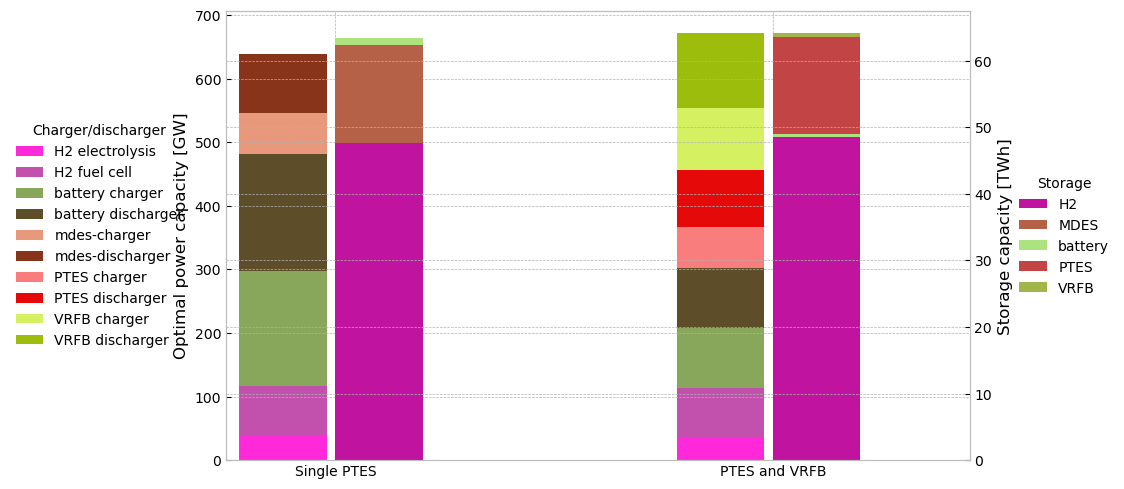

In [66]:
fig,ax1 = plt.subplots(figsize=(12,5))
fig.patch.set_facecolor('white')
ax1.set_facecolor('white')

ax1.set_ylabel('Optimal power capacity [GW]')
cap.T.div(1e3).plot(kind='bar', color=color1, stacked=True, width=0.2,position=1.1, align='center', ax=ax1)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0)
ax1.legend(title="Charger/discharger", loc='center left', bbox_to_anchor=(-0.3, 0.5), frameon=False)

ax2 = ax1.twinx()
ax2.set_ylabel('Storage capacity [TWh]')
e.T.plot(kind='bar', color=color2, stacked=True, width=0.2,align="edge",ax=ax2)
ax2.legend(title="Storage", loc='center left', bbox_to_anchor=(1.05, 0.5), frameon=False)
plt.tight_layout()
plt.show()

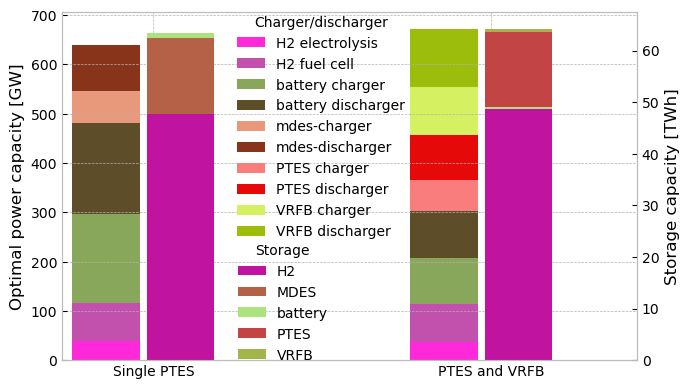

In [67]:
fig,ax1 = plt.subplots(figsize=(7,4.1))
fig.patch.set_facecolor('white')
ax1.set_facecolor('white')

ax1.set_ylabel('Optimal power capacity [GW]')
cap.T.div(1e3).plot(kind='bar', color=color1, stacked=True, width=0.2,position=1.2,ax=ax1)
ax1.legend(title="Charger/discharger", loc='center',bbox_to_anchor=(0.45, 0.67), frameon=False)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0)

ax2 = ax1.twinx()
ax2.set_ylabel('Storage capacity [TWh]')
e.T.plot(kind='bar', color=color2, stacked=True, width=0.2, position=0.6, align="edge", ax=ax2)
ax2.legend(title="Storage", loc='center', bbox_to_anchor=(0.384, 0.165),frameon=False)
plt.tight_layout()
plt.grid(False)
plt.savefig("sensitivity2.pdf", dpi=750)
plt.show()

**Sensitivity 3 impact of capital cost of onshore wind**

In [68]:
n_50 = pypsa.Network("sensitivity_3/elec_s_37_ec_lv1.25_Co2L0-2H-EQ0.8c-onwind+c0.5-MDES+c5-mdes+c11-mdes+e0.7.nc")
n_75 = pypsa.Network("sensitivity_3/elec_s_37_ec_lv1.25_Co2L0-2H-EQ0.8c-onwind+c0.75-MDES+c5-mdes+c11-mdes+e0.7.nc")
n_100 = pypsa.Network("sensitivity_3/elec_s_37_ec_lv1.25_Co2L0-2H-EQ0.8c-onwind+c1-MDES+c5-mdes+c11-mdes+e0.7.nc")
n_125 = pypsa.Network("sensitivity_3/elec_s_37_ec_lv1.25_Co2L0-2H-EQ0.8c-onwind+c1.25-MDES+c5-mdes+c11-mdes+e0.7.nc")
n_150 = pypsa.Network("sensitivity_3/elec_s_37_ec_lv1.25_Co2L0-2H-EQ0.8c-onwind+c1.5-MDES+c5-mdes+c11-mdes+e0.7.nc")

INFO:pypsa.io:Imported network elec_s_37_ec_lv1.25_Co2L0-2H-EQ0.8c-onwind+c0.5-MDES+c5-mdes+c11-mdes+e0.7.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_s_37_ec_lv1.25_Co2L0-2H-EQ0.8c-onwind+c0.75-MDES+c5-mdes+c11-mdes+e0.7.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_s_37_ec_lv1.25_Co2L0-2H-EQ0.8c-onwind+c1-MDES+c5-mdes+c11-mdes+e0.7.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_s_37_ec_lv1.25_Co2L0-2H-EQ0.8c-onwind+c1.25-MDES+c5-mdes+c11-mdes+e0.7.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_s_37_ec_lv1.25_Co2L0-2H-EQ0.8c-onwind+c1.5-MDES+c5-mdes+c11-mdes+e0.7.nc has buses, carriers, generators, global_constraints, lines, links, load

In [69]:
e_50 = n_50.stores.groupby("carrier").e_nom_opt.sum()
e_75 = n_75.stores.groupby("carrier").e_nom_opt.sum()
e_100 = n_100.stores.groupby("carrier").e_nom_opt.sum()
e_125 = n_125.stores.groupby("carrier").e_nom_opt.sum()
e_150 = n_150.stores.groupby("carrier").e_nom_opt.sum()

In [70]:
demand = pd.concat([e_50, e_75, e_100, e_125, e_150], axis=1)
demand.columns = [50, 75, 100, 125, 150]

In [71]:
demand

,50,75,100,125,150
carrier,,,,,
H2,2.664136e+02,1.334312e+07,4.767164e+07,6.308384e+07,6.884287e+07
MDES,1.748623e+07,1.805315e+07,1.474210e+07,1.199123e+07,1.186655e+07
battery,5.857984e+05,6.733058e+05,9.580506e+05,1.199584e+06,1.306648e+06


In [72]:
n_50.generators.groupby(n_50.generators.carrier).p_nom_opt.sum()

carrier
biomass        13589.758450
geothermal       766.000000
nuclear       100037.900000
offwind-ac      9571.097525
offwind-dc     15421.888637
onwind        896355.574339
ror            42522.648833
solar         484396.077011
Name: p_nom_opt, dtype: float64

In [73]:
n_150.generators.groupby(n_50.generators.carrier).p_nom_opt.sum()

carrier
biomass       1.358976e+04
geothermal    7.660000e+02
nuclear       1.000379e+05
offwind-ac    4.924662e+04
offwind-dc    4.324817e+04
onwind        2.724698e+05
ror           4.252265e+04
solar         1.264631e+06
Name: p_nom_opt, dtype: float64

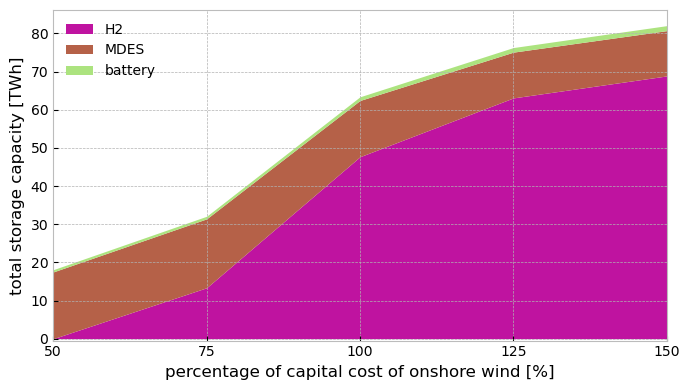

In [75]:
fig, ax = plt.subplots(figsize=(7,4))
fig.patch.set_facecolor('white')
ax.set_facecolor('white')
demand.div(1e6).T.plot.area(
    ax=ax,
    stacked=True,
    linewidth=0,
    color=demand.index.map(n_50.carriers.color),
    xlabel="percentage of capital cost of onshore wind [%]",
    ylabel="total storage capacity [TWh]",
    xlim=(50,150))

ax.set_xticks(range(50, 151, 25))
ax.set_ylim(bottom=-0.5)
plt.legend(frameon=False)
plt.tight_layout()
plt.savefig("sensitivity3.pdf",dpi=750)
plt.show()

In [76]:
n_100.generators.capital_cost[n_100.generators.capital_cost.index.str.contains("onwind")]

Generator
AL1 0 onwind    88974.573629
AT1 0 onwind    88974.573629
BA1 0 onwind    88974.573629
BE1 0 onwind    88974.573629
BG1 0 onwind    88974.573629
CH1 0 onwind    88974.573629
CZ1 0 onwind    88974.573629
DE1 0 onwind    88974.573629
DK1 0 onwind    88974.573629
DK2 0 onwind    88974.573629
EE6 0 onwind    88974.573629
ES1 0 onwind    88974.573629
ES4 0 onwind    88974.573629
FI2 0 onwind    88974.573629
FR1 0 onwind    88974.573629
GB0 0 onwind    88974.573629
GB5 0 onwind    88974.573629
GR1 0 onwind    88974.573629
HR1 0 onwind    88974.573629
HU1 0 onwind    88974.573629
IE5 0 onwind    88974.573629
IT1 0 onwind    88974.573629
IT3 0 onwind    88974.573629
LT6 0 onwind    88974.573629
LU1 0 onwind    88974.573629
LV6 0 onwind    88974.573629
ME1 0 onwind    88974.573629
MK1 0 onwind    88974.573629
NL1 0 onwind    88974.573629
NO2 0 onwind    88974.573629
PL1 0 onwind    88974.573629
PT1 0 onwind    88974.573629
RO1 0 onwind    88974.573629
RS1 0 onwind    88974.573629
SE2 